<a href="https://colab.research.google.com/github/Eduard25/Redes/blob/master/Tarea6-4-1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, Layer, Input
from keras.optimizers import RMSprop, Adam

from matplotlib import pyplot as plt
import numpy as np
import math

In [19]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min = tf.cast(tf.reduce_min(data),tf.float32)
         max = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size,1), minval=-5, maxval=5)

         with tf.GradientTape() as tape:
             with tf.GradientTape(persistent=True) as tape2:
                 tape2.watch(x)
                 y_pred = self(x, training=True)
             dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
             d_yy = tape2.gradient(dy, x)
             x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
             y_o = self(x_o,training=True) #valor del modelo en en x_0
             eq = x*dy + y_pred - x**2*tf.math.cos(x)  #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
             ic = 0. #valor que queremos para la condicion inicial o el modelo en x_0
             loss = self.mse(0., eq) + self.mse(y_o,ic)

       # Apply grads
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
         return {"loss": self.loss_tracker.result()}

In [20]:
mse = tf.keras.losses.MeanSquaredError()
mse([[3],[5]], [[2],[1]])

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [21]:
keras.losses.mean_squared_error([[3],[5]], [[2],[1]])

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 1, 16], dtype=int32)>

In [22]:
model = ODEsolver()

model.add(Dense(10, activation='tanh', input_shape=(1,)))
model.add(Dense(1, activation='tanh'))
model.add(Dense(1))


model.summary()

Model: "od_esolver_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                20        
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
Total params: 33 (132.00 Byte)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


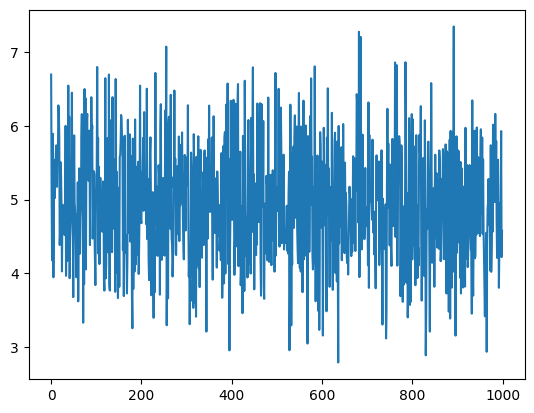

In [32]:
model.compile(optimizer=Adam(),metrics=['loss'])

x=tf.linspace(-5,5,500)
history = model.fit(x,epochs=1000,verbose=0)
plt.plot(history.history["loss"])

16/16 [==============================] - 0s 2ms/step


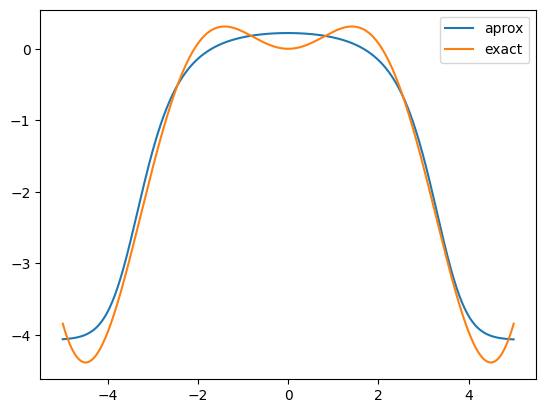

In [33]:
x_testv = tf.linspace(-5,5,500)
a=model.predict(x_testv)
plt.plot(x_testv,a,label="aprox")
plt.plot(x_testv,((x**2 - 2)/x) * tf.sin(x) + 2*tf.cos(x),label="exact")
plt.legend()
plt.show()